In [1]:
import random
from collections import OrderedDict
import os
import matplotlib.pyplot as plt

In [2]:
class EvolvingGraphPageRank():
    
    def __init__(self):
        self.initial_graph = {} # The first constructed graph
        self.new_graph = {} # latest graph after running construct_new_graph()
        self.updated_graph = {} # The updated graph after running construct_new_graph() and update_graph()
        self.image = OrderedDict() # The graph updated based on probing
        self.current_pagerank = {} # PageRank latest graph after running construct_new_graph()
        self.updated_pagerank = {} # PageRank of the updated graph after running construct_new_graph() and update_graph()
        self.num_changes = 0
        self.probe_pagerank = {}
        self.updated_pagerank = {}
        self.probenode = 0
        self.probeneighbours = []
        self.probe_changes = 0
        self.L_inf = OrderedDict()
        self.L1 = OrderedDict()
        self.priority = OrderedDict()

        
    def construct_first_graph(self, filepath):
        with open(filepath) as file:
            df = file.readlines()[4:]
        for line in df:
            f, t = line.split()
            f, t = int(f), int(t) 
            if f not in self.initial_graph:
                self.initial_graph[f] = []
                self.updated_graph[f] = []
                self.image[f] = []
            self.initial_graph[f].append(t)
            self.updated_graph[f].append(t)        
            self.image[f].append(t)      
        self.probe_pagerank = self.PowerIteration(0.15, self.initial_graph)

    def construct_new_graph(self, filepath):
        with open(filepath) as file:
            df = file.readlines()[4:]
        for line in df:
            f, t = line.split()
            f, t = int(f), int(t) 
            if f not in self.new_graph:
                self.new_graph[f] = []
            self.new_graph[f].append(t)
        
        
    def update_image(self):
        
        if self.probenode in self.updated_graph:
            if sorted(self.probeneighbours) == sorted(self.updated_graph[self.probenode]):
                pass
            else:
                for i in self.probeneighbours:
                    if i not in self.updated_graph[self.probenode]:
                        self.image[self.probenode].remove(i)
                        self.probe_changes+=1
                
                for i in self.updated_graph[self.probenode]:
                    if i not in self.probeneighbours:
                        if i not in self.image:
                            self.image[i] = []
                        self.image[self.probenode].append(i)
                        self.probe_changes+=1
                        
        else:
            for i in list(self.image.keys()):
                if self.probenode in self.image[i]:
                    self.image[i].remove(self.probenode)
                    self.probe_changes+=1
            self.image.pop(self.probenode)
            
        self.probe_pagerank = self.PowerIteration(0.15, self.image)
        self.updated_pagerank = self.PowerIteration(0.15, self.updated_graph)
        
        
        
        
    def update_graph(self, method = 'Random'):
        for node in self.new_graph: 
            if node in self.updated_graph:
                if sorted(self.new_graph[node]) == sorted(self.updated_graph[node]): # checking if neighbours matches for nodes in both new and updated graphs
                    pass
                else: 
                    for i in self.new_graph[node]:                     # adding neighbours
                        if i not in self.updated_graph[node]:
                            if i not in self.updated_graph:
                                self.updated_graph[i] = []
                            self.updated_graph[node].append(i)
                            if method == 'Random':
                                self.random_probing()
                                self.update_image()

                            elif method == 'RoundRobin':
                                self.roundrobin_probing()
                                self.update_image()

                            elif method == 'Proportional':
                                self.proportional_probing()
                                self.update_image()

                            elif method == 'Priority':
                                self.priority_probing()
                                self.update_image()
                            self.metrics()
                            self.num_changes += 1

                    temp = self.updated_graph[node].copy()
                    for i in temp:                                    # removing neighbours
                        if i not in self.new_graph[node]:
                            self.updated_graph[node].remove(i)
                            
                            if method == 'Random':
                                self.random_probing()
                                self.update_image()

                            elif method == 'RoundRobin':
                                self.roundrobin_probing()
                                self.update_image()

                            elif method == 'Proportional':
                                self.proportional_probing()
                                self.update_image()

                            elif method == 'Priority':
                                self.priority_probing()
                                self.update_image()
                            self.metrics()
                            self.num_changes += 1
                    
            elif node not in self.updated_graph:
                
                temp = self.new_graph[node].copy()
                self.updated_graph[node] = []
                for i in temp:
                    if i not in self.updated_graph:
                        self.updated_graph[i] = []
                    self.updated_graph[node].append(i)
                    if method == 'Random':
                        self.random_probing()
                        self.update_image()

                    elif method == 'RoundRobin':
                        self.roundrobin_probing()
                        self.update_image()

                    elif method == 'Proportional':
                        self.proportional_probing()
                        self.update_image()

                    elif method == 'Priority':
                        self.priority_probing()
                        self.update_image()
                    self.metrics()
                    self.num_changes += 1
                    
                    
                    
        for i in list(self.updated_graph.keys()): # removing nodes not in new graph
            if i not in self.new_graph:
                self.updated_graph.pop(i) # node removed
                
                
        return self.L_inf, self.L1
            
    
    def PowerIteration(self, alpha, graph):
        pi_prev = {node: 1 / len(graph) for node in graph}
        pi_current = {node: 0 for node in graph}
        abs_diff = max([abs(pi_prev[node] - pi_current[node]) for node in graph])
        while abs_diff >= 1e-9:
            for node, neighbors in graph.items():
                if len(neighbors) > 0:
                    for neighbor_node in neighbors:
                        if neighbor_node in graph:
                            pi_current[neighbor_node] += pi_prev[node] / len(neighbors)
            pi_current = {node: (1 - alpha) * pi_current[node] + alpha / len(graph) for node in graph}
            abs_diff = max([abs(pi_prev[node] - pi_current[node]) for node in graph])
            pi_prev = pi_current
            pi_current = {node: 0 for node in graph}
        for node in pi_prev:
            pi_prev[node] = pi_prev[node] / 7716

        return pi_prev
    

    
    
    
    def random_probing(self):
        self.probenode = random.choice(list(self.image.keys()))
        self.probeneighbours = self.image[self.probenode]
        
        
        
    def roundrobin_probing(self):
        if self.probe_changes == 0:
            self.probenode = list(self.image.keys())[0]
        else:
            if self.probenode == list(self.image.keys())[-1]:
                self.probenode = list(self.image.keys())[0]
            else:
                self.probenode = list(self.image.keys())[list(self.image.keys()).index(self.probenode) + 1]
        
        
    def proportional_probing(self):
        pagerank_weights = {}
        sum_ = sum([self.probe_pagerank[i] for i in self.probe_pagerank])
        
        for node in self.probe_pagerank:
            pagerank_weights[node] = self.probe_pagerank[node] / sum_
            
        self.probenode = random.choices(list(self.image), weights = pagerank_weights)[0]
        self.probeneighbours = self.image[self.probenode]
        
        
    def priority_probing(self):
        for node in self.image.keys():
            if node not in self.priority:
                self.priority[node] = 0
                
        max_priority = max([self.priority[i] for i in self.priority])
        max_indices = [i for i, x in enumerate(list(self.priority.values())) if x == max_priority]
        if len(max_indices) > 1:
            random_index = random.choice(max_indices)
            self.probenode = list(self.image.keys())[random_index]
        elif len(max_indices) == 1:
            self.probenode = list(self.image.keys())[max_indices[0]]
        
        self.probeneighbours = self.image[self.probenode]
        
        self.priority[self.probenode] = 0
        
        for node in self.priority:
            if node != self.probenode:
                self.priority[node] += self.probe_pagerank[node]        

        
    def metrics(self):
        
        if self.probenode not in self.L_inf:
            self.L_inf[self.probenode] = 0
            
        self.L_inf[self.probenode] = max([abs(self.probe_pagerank[node] - self.updated_pagerank[node]) for node in self.image if node in self.updated_graph]) 
        
        if self.probenode not in self.L1:
            self.L1[self.probenode] = 0
        
        self.L1[self.probenode] = sum([abs(self.probe_pagerank[node] - self.updated_pagerank[node]) for node in self.image if node in self.updated_graph]) 
        

In [3]:
roundrobinprobinggraph = EvolvingGraphPageRank()
roundrobinprobinggraph.construct_first_graph("as-733/as19971108.txt")
directory = 'as-733'
c = 0

for filename in os.listdir(directory):
    c += 1
    print(c, filename)
    if c != 1:
        roundrobinprobinggraph.construct_new_graph(f"{directory}/{filename}")
        roundrobinprobinggraph.update_graph(method = 'RoundRobin')
        



1 as19971108.txt
2 as19971109.txt
3 as19971110.txt
4 as19971111.txt
5 as19971112.txt
6 as19971113.txt
7 as19971114.txt
8 as19971115.txt
9 as19971116.txt
10 as19971117.txt
11 as19971118.txt
12 as19971119.txt
13 as19971120.txt
14 as19971121.txt
15 as19971122.txt
16 as19971123.txt
17 as19971124.txt
18 as19971125.txt
19 as19971126.txt
20 as19971127.txt
21 as19971128.txt
22 as19971129.txt
23 as19971130.txt
24 as19971201.txt
25 as19971202.txt
26 as19971203.txt
27 as19971204.txt
28 as19971205.txt
29 as19971206.txt
30 as19971207.txt
31 as19971208.txt
32 as19971209.txt
33 as19971210.txt
34 as19971211.txt
35 as19971212.txt
36 as19971213.txt
37 as19971214.txt
38 as19971215.txt
39 as19971216.txt
40 as19971217.txt
41 as19971218.txt
42 as19971219.txt
43 as19971220.txt
44 as19971221.txt
45 as19971222.txt
46 as19971223.txt
47 as19971224.txt
48 as19971225.txt
49 as19971226.txt
50 as19971227.txt
51 as19971228.txt
52 as19971229.txt
53 as19971230.txt
54 as19971231.txt
55 as19980101.txt
56 as19980102.txt
5

KeyboardInterrupt: 

1 1 7.315135519906239e-07
2 3 7.324482093560154e-07
3 6 7.345526023813592e-07
4 7 7.330387680377883e-07
5 9 7.329268635702708e-07
6 13 7.319785773464861e-07
7 16 7.335443790444523e-07
8 17 7.335527057623762e-07
9 22 7.334064470142876e-07
10 25 7.334346867684599e-07
11 26 7.327433359981233e-07
12 27 7.328410300427633e-07
13 31 7.327905726965585e-07
14 32 7.343635231728668e-07
15 33 7.359533610099102e-07
16 34 7.36874685980738e-07
17 35 7.36689115976173e-07
18 38 7.364193808625276e-07
19 41 7.363220301438462e-07
20 43 7.355021401910658e-07
21 45 7.347038552001243e-07
22 46 7.339055015611977e-07
23 48 7.324301909095114e-07
24 49 7.314506928881682e-07
25 50 7.2915251706496e-07
26 52 7.290064266660452e-07
27 55 7.290377765815304e-07
28 68 7.297832441785977e-07
29 70 7.302138383026464e-07
30 71 7.313947844353394e-07
31 72 7.318978252851805e-07
32 73 7.270757543455303e-07
33 74 7.274128933761928e-07
34 77 7.297690158857975e-07
35 80 7.297125508077628e-07
36 81 7.31785176196332e-07
37 83 7.337

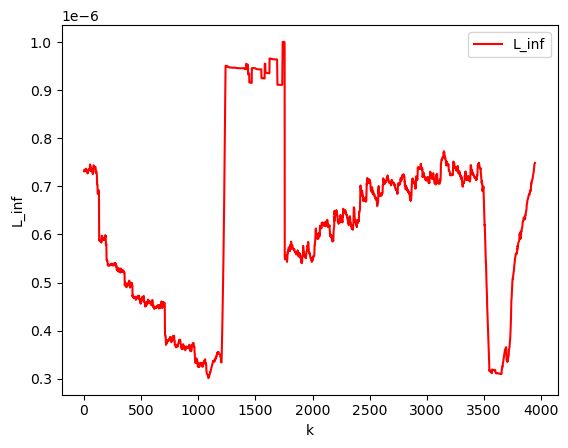

In [19]:
k = 0
k_values = []
L_inf_values = []

for _, L_inf in roundrobinprobinggraph.L_inf.items():
    k += 1
    k_values.append(k)
    L_inf_values.append(L_inf)
    print(k, _, L_inf)



plt.plot(k_values, L_inf_values, color='red', label='L_inf')
plt.xlabel('k')
plt.ylabel('L_inf')
plt.legend()
plt.show() 

1 2.3584680567727363e-05
2 2.3593050076685683e-05
3 2.3593359889382177e-05
4 2.3593198194087606e-05
5 2.3595021662081986e-05
6 2.3591179142536883e-05
7 2.3601974073877683e-05
8 2.360353276187829e-05
9 2.3609339417115985e-05
10 2.3612947543839514e-05
11 2.360339021181098e-05
12 2.359355786522156e-05
13 2.3579345477355405e-05
14 2.358336163004197e-05
15 2.3587946446501435e-05
16 2.3595271331113722e-05
17 2.3596888958597308e-05
18 2.3599307233589947e-05
19 2.361116386635039e-05
20 2.362054592910566e-05
21 2.3628759918382453e-05
22 2.3639058957688058e-05
23 2.3636171462568063e-05
24 2.3612057169962016e-05
25 2.359790085102285e-05
26 2.359696466346723e-05
27 2.3601145252396624e-05
28 2.3604840327705156e-05
29 2.3602020152885652e-05
30 2.3607003326026587e-05
31 2.3603932015936773e-05
32 2.3602014720917968e-05
33 2.3607007335938974e-05
34 2.3621305328430893e-05
35 2.362568439032965e-05
36 2.3641525511292085e-05
37 2.365393143721787e-05
38 2.3660785033278394e-05
39 2.3665230187458146e-05
40 2.

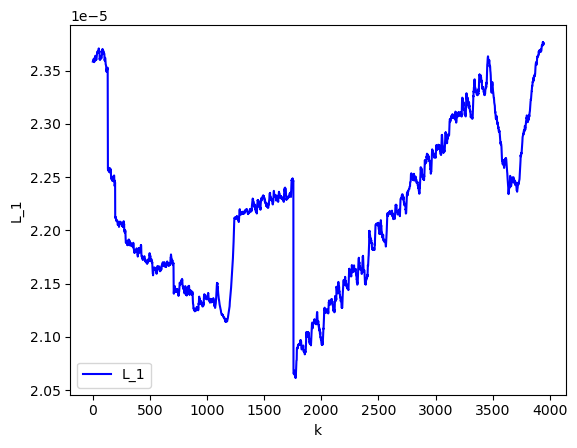

In [18]:
k = 0
k_values = []
L_1_values = []


for _, L_1 in roundrobinprobinggraph.L1.items():
    k += 1
    L_1_values.append(L_1)
    k_values.append(k)
    print(k, L_1)
print(len(k_values), len(L_1_values))
plt.plot(k_values, L_1_values, color='blue', label='L_1')
plt.xlabel('k')
plt.ylabel('L_1')

plt.legend()
plt.show() 

In [3]:
# priorityprobinggraph = EvolvingGraphPageRank()
# priorityprobinggraph.construct_first_graph("as-733/as19971108.txt")
# directory = 'as-733'
# c = 0

# for filename in os.listdir(directory):
#     c += 1
#     print(".", end="")
#     if c != 1:
#         priorityprobinggraph.construct_new_graph(f"{directory}/{filename}")
#         priorityprobinggraph.update_graph(method = 'Priority')
# k = 0
# k_values = []
# L_inf_values = []
# L_1_values = []

# for _, L_inf in priorityprobinggraph.L_inf.items():
#     k += 1
#     k_values.append(k)
#     L_inf_values.append(L_inf)
#     print(".", end="")

# for _, L_1 in priorityprobinggraph.L_1.items():
#     L_1_values.append(L_1)
#     print(".", end="")

# plt.scatter(k_values, L_inf_values, color='red', label='L_inf')
# plt.scatter(k_values, L_1_values, color='blue', label='L_1')
# plt.xlabel('k')
# plt.ylabel('L_inf and L_1')
# plt.legend()
# plt.show()
        
        

In [1]:
# randomprobinggraph = EvolvingGraphPageRank()
# randomprobinggraph.construct_first_graph("as-733/as19971108.txt")
# directory = 'as-733'
# c = 0

# for filename in os.listdir(directory):
#     c += 1
#     print(".", end="")
#     if c != 1:
#         randomprobinggraph.construct_new_graph(f"{directory}/{filename}")
#         randomprobinggraph.update_graph(method = 'Random')
# k = 0
# k_values = []
# L_inf_values = []
# L_1_values = []

# for _, L_inf in randomprobinggraph.L_inf.items():
#     k += 1
#     k_values.append(k)
#     L_inf_values.append(L_inf)
#     print(".", end="")
    
# for _, L_1 in priorityprobinggraph.L_1.items():
#     L_1_values.append(L_1)
#     print(".", end="")

# plt.scatter(k_values, L_inf_values, color='red', label='L_inf')
# plt.scatter(k_values, L_1_values, color='blue', label='L_1')
# plt.xlabel('k')
# plt.ylabel('L_inf and L_1')
# plt.legend()
# plt.show()
        
        

In [2]:
# proportionalprobinggraph = EvolvingGraphPageRank()
# proportionalprobinggraph.construct_first_graph("as-733/as19971108.txt")
# directory = 'as-733'
# c = 0

# for filename in os.listdir(directory):
#     c += 1
#     print(".", end="")
#     if c != 1:
#         proportionalprobinggraph.construct_new_graph(f"{directory}/{filename}")
#         proportionalprobinggraph.update_graph(method = 'Proportional')
# k = 0
# k_values = []
# L_inf_values = []
# L_1_values = []

# for _, L_inf in proportionalprobinggraph.L_inf.items():
#     k += 1
#     k_values.append(k)
#     L_inf_values.append(L_inf)
#     print(".", end="")
    
# for _, L_1 in proportionalprobinggraph.L_1.items():
#     L_1_values.append(L_1)
#     print(".", end="")

# plt.scatter(k_values, L_inf_values, color='red', label='L_inf')
# plt.scatter(k_values, L_1_values, color='blue', label='L_1')
# plt.xlabel('k')
# plt.ylabel('L_inf and L_1')
# plt.legend()
# plt.show()
        
        

In [20]:
import pandas as pd
d = {"L_1_values": L_1_values, "L_inf_values": L_inf_values}
df = pd.DataFrame(data = d)

In [22]:
df.to_csv("AS_RoundRobin.csv")